In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import img_to_array
from skimage.transform import resize
from sklearn.metrics import confusion_matrix

The ImageDataGenerator specifies how the images that will be loaded are to be used for training.
Using a generator improves the model, because we are 'generating' additional images above and beyond
the available images to train the model on. 

In this case, we are allowing images to be created that are rescaled to a values between 0 - 1
(optimizes training - value, shape and number of images doesn't change), THEN they are:

- distorted to a max shear degree (check out https://www.tutorialspoint.com/javafx/shearing_transformation),
- randomly zoomed in or out within the defined range and (additional images created)
- are mirror flipped (doubling the initial number of images!)  

This basically gives the computer a 'look' at many variation of the same object without requiring additional source data.
We do not augment the test data as we are simplying validating the trained model the actual images are sufficient.

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,)

test_datagen = ImageDataGenerator(rescale = 1./255,)

**Locate and assign Training Set using the Keras built in capability to read from directory**
Point to the file path on your own computer!
Notes:
- 'binary' is looking for only 2 folders for classes. Categorical for multiclass
- Shuffle is True because we read these images in, in order, but we don't want to train all
  of one category then the next, it will bias the model, so we want to shuffle
- 64 refers to the size of matrix we want to save the pixel data in.   

In [3]:
training_set = train_datagen.flow_from_directory('training_set/',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle = True)

Found 8000 images belonging to 2 classes.


**Locate and assign Test Set**

Note shuffle = False, so we can compare the labels with the images for sanity checking

In [4]:
test_set = test_datagen.flow_from_directory('test_set/',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle = False)

Found 2000 images belonging to 2 classes.


# Visualize data shape

In [5]:
print("Train Data = ", len(training_set.filepaths))
print("Test Data = ", len(test_set.filepaths))

Train Data =  8000
Test Data =  2000


# Display one of the training samples

In [6]:
# labels_array = np.argwhere(training_set.labels > 0).ravel()
# type(image_idx[0])

# Dog

Text(0.5, 1.0, '1')

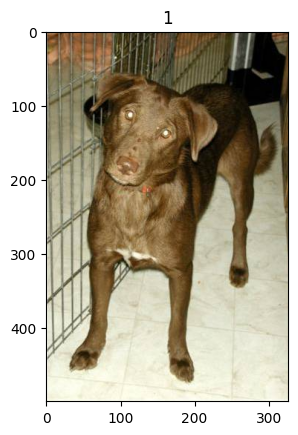

In [7]:
dogs_idxs = np.argwhere(training_set.labels > 0).ravel()
image_idx = dogs_idxs[0]
image_path = training_set.filepaths[image_idx]
image_obj = mpimg.imread(image_path)
image_obj = image_obj/255
image_obj = img_to_array(image_obj)
plt.imshow(image_obj)
plt.title(str(training_set.labels[image_idx]))

# Cat

Text(0.5, 1.0, '0')

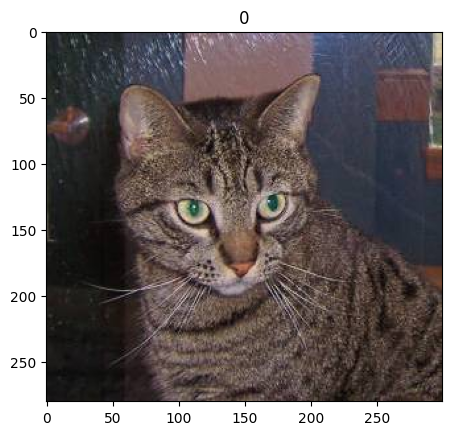

In [8]:
cats_idxs = np.argwhere(training_set.labels < 1).ravel()
image_idx = cats_idxs[0]
image_path = training_set.filepaths[image_idx]
image_obj = mpimg.imread(image_path)
image_obj = image_obj/255
image_obj = img_to_array(image_obj)
plt.imshow(image_obj)
plt.title(str(training_set.labels[image_idx]))

### Design the CNN Architecture

In [9]:
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.25))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.25))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.2))

classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.2))

# Output layer
classifier.add(Dense(units = 1, activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 32)      

# Train the CNN

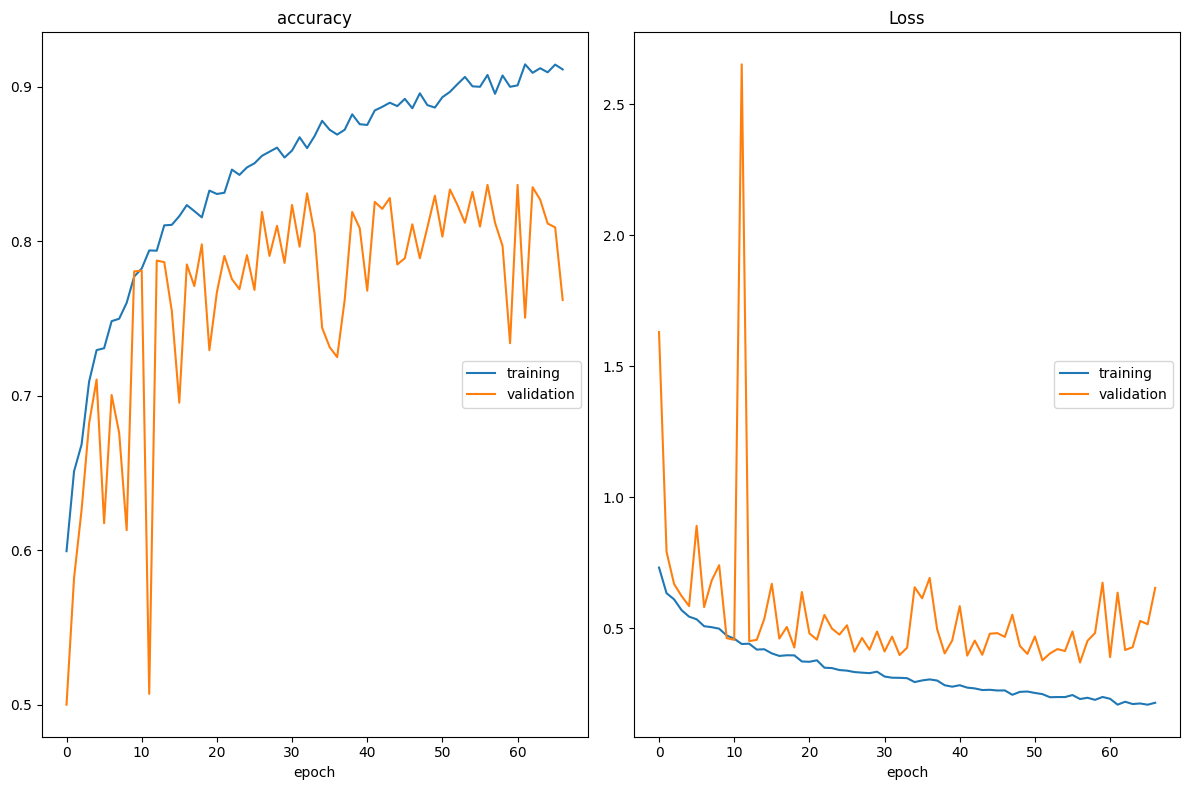

accuracy
	training         	 (min:    0.599, max:    0.915, cur:    0.911)
	validation       	 (min:    0.500, max:    0.836, cur:    0.762)
Loss
	training         	 (min:    0.209, max:    0.732, cur:    0.217)
	validation       	 (min:    0.370, max:    2.653, cur:    0.655)


In [10]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
classifier.fit(training_set,
               steps_per_epoch = 200,
               epochs = 100,
               validation_data = test_set,
               callbacks=[PlotLossesKeras(),early_stopping],
               verbose=0)

# Test the CNN

In [11]:
y_pred = classifier.predict(test_set)
y_pred = np.round(y_pred)
y_test = test_set.labels

(tn, fp, fn, tp) = confusion_matrix(y_test, y_pred).ravel()

precision_val = float(tp)/float(tp+fp)
recall_val = float(tp)/float(tp+fn)
specificity_val = float(tn)/float(tn+fp)
accuracy_val = float(tp+tn)/float(tn+fp+fn+tp)
f1_val = (2*tp)/(2*tp+fp+fn)
mcc_val = float((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


print("\n")
print("Test set precision_val =", precision_val)
print("Test set recall_val =", recall_val)
print("Test set sspecificity =", specificity_val)
print("Test set mcc_val =", mcc_val)
print("Test set accuracy_val =", accuracy_val)
print("Test set f1_val =", f1_val)

63/63 [==============================] - 4s 60ms/step


Test set precision_val = 0.850156087408949
Test set recall_val = 0.817
Test set sspecificity = 0.856
Test set mcc_val = 0.6735124010956944
Test set accuracy_val = 0.8365
Test set f1_val = 0.833248342682305
